# Vanilla Models

In this notebook, you will find the baseline models, also known as vanilla models. For the baseline models, I will run Logistic Regression, which is a basic but reliable model - it works well with binary classification?; Random Forest because I believe a Decision Tree could bring me good results but since Random Forest is a collection of Decision Trees, I can skip it and start with Random Forest; Naive Bayes, which is know for giving good results when applied to NLP; and Support Vector Machine, which is also known for working well with Natural Language Processing.

I will try the vanilla models with the datasets vectorized with CountVectorizer, TF-IDF. I will try these models with and without lemmatization. I will also iterate the best models with a train set using SMOTE. I have fixed the class imbalance manually in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/data-cleaning.ipynb">Data Cleaning</a> notebook. However, I'm curious to see if the models could have any improvement with SMOTE. I will use the `Spell_Checked` feature, since it's the cleanest one. I will not include other features from the original data set because the main objective is train a model using the reviews only.

I have a binary classification, where the target will be 0 for negative review and 1 for positive review.

## Objectives

- Preprossess the dataset creating train and test datasets
- Run models for each vectorizer used
- Find the best models for each category
- Evaluate Results

# Importing

In this section, we will import important packages and the data set we will use, which was already cleaned in the Data Cleaning notebook.

In [59]:
# Basic Packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP Packages
import nltk 
from nltk.corpus import stopwords

# WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Sklearn Packages
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from IPython.core.display import display, HTML
from sklearn.model_selection import cross_val_score

# Pandas Settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Solve warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Import pickle
import pickle

In [60]:
from functions import evaluation
from functions import cross_validation

## Importing DataFrame

Importing the main dataset and the lemmatized X and y variables

In [61]:
# Importing cleaned dataset as a DataFrame
df = pd.read_csv('../csv/Hotel_Review_Spell_Checked.csv', index_col=0)

In [62]:
# Checking DataFrame
df.head(2)

,Unnamed: 0.1,Hotel_Name,Negative_Review,Positive_Review,Reviewer_Score,Reviews_Clean,Score,Spell_Checked
0,185010,St James Court A Taj Hotel London,No Negative,the location was perfect,9.6,no negative the location was perfect,1,no negative the location was perfect
1,424531,H10 Metropolitan 4 Sup,Nothing,Everything was top notch staff were impeccable,10.0,nothing everything was top notch staff were ...,1,nothing everything was top notch staff were ...


### Importing Lemmatized X and Y Variables

I lemmatized the feature variable `Spell_Checked` in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/preprossessing/data-cleaning.ipynb">Data Cleaning</a> notebook.

In [63]:
# Importing lemmatized X and y variable
X_lem = pickle.load(open('../pickle/X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('../pickle/y_lem.pkl')

# Preprocessing

In [64]:
# Importing stop_words
stop_words = stopwords.words('english')

In [65]:
# Dropping null values, if any
df.dropna(inplace=True)

## Train Test Split

As mentioned in the introduction, I will use the column `Spell_Checked` to create the features and `Score` as my target.

In [66]:
# Creating an X variable and y for my target
X = df.Spell_Checked
y = df.Score

In [67]:
# Splitting the dataset in train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Train Test Split with Lemmatization

In [68]:
# Splitting the lemmatized dataset in train set and test set
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.25, random_state=15)

## Count Vectorizer

In [69]:
# Instantiate CountVectorizer
cv = CountVectorizer(stop_words=stop_words)

# Fitting into the train and test set
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

## TF-IDF

In [70]:
# Instantiate TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=stop_words)

# Fitting into the train and test set
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [71]:
# Convert TF-IDF Vector back to a dataframe so I can get feature importance later
X_train_tfidf_sparse = pd.DataFrame.sparse.from_spmatrix(
    X_train_tfidf, columns=tfidf.get_feature_names())
X_test_tfidf_sparse = pd.DataFrame.sparse.from_spmatrix(
    X_test_tfidf, columns=tfidf.get_feature_names())

In [72]:
X_train_tfidf = X_train_tfidf_sparse
X_test_tfidf = X_test_tfidf_sparse

### TF-DF With Lemmatization

In [73]:
# Fitting into the lemmatized train and test set
X_train_lem = tfidf.fit_transform(X_train_lem)
X_test_lem = tfidf.transform(X_test_lem)

## Evaluation Metric

My main focus is the accuracy metric. Have an accurate is important to be accurate. However, although fixing False Negatives is not crucial, I will also take a look at Recall and F1-Score to understand how my model is working. Since it is not my main focus, I will not mentioned in the individual analysis on my models.

# Vanilla Models

In this section, I will run the Logistic Regression, Random Forest, Naive Bayes, and SVC models for the dataset that was vectorized using Count Vectorizer. Then, I will pick the three best models and move to the next section, which will be using TF-IDF.

I will also create dictionaries for each model so that I will be able to create a DataFrame with the models' results. For better visualization, I will evaluate each model by the end of each section.


<b>Note:</b> You will see that I will instantiate the same model multiple times. This will be done so that you can run each model individually, without having the run all the cells for each model.

In [74]:
!pip install lazypredict
!pip install lightgbm

In [85]:
!pip install pytest

     |████████████████████████████████| 279 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 1.6 MB/s eta 0:00:01


In [82]:
import lightgbm

In [83]:
import lazypredict

In [86]:
from lazypredict.Supervised import LazyClassifier

In [91]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_tfidf, X_test_tfidf, y_train, y_test)
models

100%|██████████| 30/30 [03:24<00:00,  6.80s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,


In [90]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,


## Modeling With Count Vectorizer

In this section, I will run the Logistic Regression, Random Forest, Naive Bayes, and SVC models for the dataset that was vectorized using Count Vectorizer. Then, I will pick the three best models and move to the next section, which will be using TF-IDF.

### Logistic Regression

In [16]:
# Instantiating baseline Logistic Regression Model
lg_cv = LogisticRegression()

# Fitting the model to the X and y variables of the train set
lg_cv.fit(X_train_cv, y_train)

# Predicting the model in the X variable of the test set
y_lg_cv = lg_cv.predict(X_test_cv)

In [17]:
# Creating dictionary with all metrics
lr_cv_accuracy = accuracy_score(y_test, y_lg_cv)
lr_cv_precision = precision_score(y_test, y_lg_cv)
lr_cv_recall = recall_score(y_test, y_lg_cv)
lr_cv_f1 = f1_score(y_test, y_lg_cv)

metric_dict = {}
metric_dict['Vanilla Logisitic Regression CV'] = {'Accuracy': lr_cv_accuracy,
                                                'Precision': lr_cv_precision,
                                                'Recall': lr_cv_recall,
                                                'F1 Score': lr_cv_f1}

In [18]:
# Logistic Regression baseline evaluation
evaluation(y_test, y_lg_cv)
cross_validation(lg_cv, X_train_cv, y_train, 5)

Evaluation Metrics:
Accuracy: 0.798149861239593
Precision: 0.8104575163398693
Recall: 0.7968582649053909
F1 Score: 0.8036003600360035

Cross-Validation Accuracy Scores: [0.80758557 0.80049337 0.80080173 0.80727721 0.81431215]
Min:  0.800493
Max:  0.814312
Mean:  0.806094
Range:  0.013819


In [19]:
# Evaluation DataFrame
evaluation_df = pd.DataFrame.from_dict(metric_dict, orient='index')
evaluation_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanilla Logisitic Regression CV,0.79815,0.810458,0.796858,0.8036


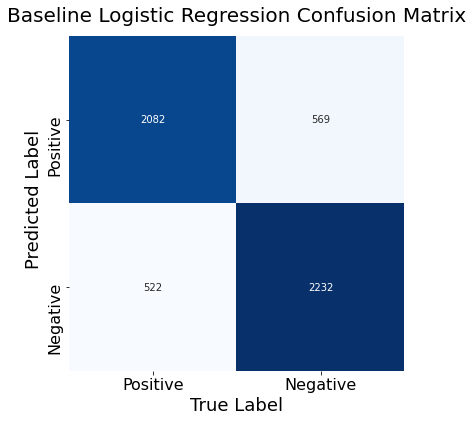

In [20]:
# Plotting a confusion matrix
plt.figure(figsize=(6, 7))
mat = confusion_matrix(y_test, y_lg_cv)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], cmap="Blues")
plt.xlabel('True Label', fontsize= 18)
plt.ylabel('Predicted Label', fontsize= 18)
plt.title('Baseline Logistic Regression Confusion Matrix', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
b, t = plt.ylim() 
t -= 0.05 
plt.ylim(b, t) 
plt.savefig('../images/confusion-matrix-baseline-lg-model.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

For the first model, Logistic Regression performed quite well with an accuracy of 0.7981. My main metric is accuracy and it seems that Logistic Regression is able to correctly understand the positive and negative reviews. Looking at the cross validations, it seems that the train set performs similar to the test set with a small difference.

### Random Forest

In [21]:
# Instantiating baseline Random Forest Model
rf_baseline = RandomForestClassifier(n_jobs=-1)

# Fitting the model to the X and y variables of the train set
rf_baseline.fit(X_train_cv, y_train)

# Predicting the model in the X variable of the test set
y_rf_cv = rf_baseline.predict(X_test_cv)

In [22]:
# Creating dictionary with all metrics
rf_cv_accuracy = accuracy_score(y_test, y_rf_cv)
rf_cv_precision = precision_score(y_test, y_rf_cv)
rf_cv_recall = recall_score(y_test, y_rf_cv)
rf_cv_f1 = f1_score(y_test, y_rf_cv)

metric_dict['Vanilla Random Forest CV'] = {'Accuracy': rf_cv_accuracy,
                                                'Precision': rf_cv_precision,
                                                'Recall': rf_cv_recall,
                                                'F1 Score': rf_cv_f1 }

In [23]:
# Random Forest baseline evaluation
evaluation(y_test, y_lg_cv)
cross_validation(rf_baseline, X_train_cv, y_train, 5)

Evaluation Metrics:
Accuracy: 0.798149861239593
Precision: 0.8104575163398693
Recall: 0.7968582649053909
F1 Score: 0.8036003600360035

Cross-Validation Accuracy Scores: [0.79925994 0.79895159 0.79494295 0.81683626 0.81770512]
Min:  0.794943
Max:  0.817705
Mean:  0.805539
Range:  0.022762


Random Forest was able to do slightly better than Logistic Regression with an accuracy of 0.8031. Let's see if other models are able to perform better than that. Similarly to Logistic Regression, when looking at cross validation, we can see that the model performed similarly in train set and test set with no signs of overfitting.

### Naive Bayes

In [24]:
# Instantiating baseline Naive Bayes Model
nb_base_cv = MultinomialNB(alpha = .01)

# Fitting the model to the X and y variables of the train set
nb_base_cv.fit(X_train_cv, y_train)

# Predicting the model in the X variable of the test set
y_nb_base_cv = nb_base_cv.predict(X_test_cv)

In [25]:
# Creating dictionary with all metrics
nb_cv_accuracy = accuracy_score(y_test, y_nb_base_cv)
nb_cv_precision = precision_score(y_test, y_nb_base_cv)
nb_cv_recall = recall_score(y_test, y_nb_base_cv)
nb_cv_f1 = f1_score(y_test, y_nb_base_cv)

metric_dict['Vanilla Naive Bayes CV'] = {'Accuracy': nb_cv_accuracy,
                                                'Precision': nb_cv_precision,
                                                'Recall': nb_cv_recall,
                                                'F1 Score': nb_cv_f1 }

In [26]:
# Naive Bayes baseline evaluation
evaluation(y_test, y_nb_base_cv)
cross_validation(nb_base_cv, X_train_cv, y_train, 5)

Evaluation Metrics:
Accuracy: 0.7811285846438483
Precision: 0.7935413642960812
Recall: 0.7807925740806855
F1 Score: 0.7871153500089977

Cross-Validation Accuracy Scores: [0.78939254 0.79925994 0.77582485 0.79401788 0.80289944]
Min:  0.775825
Max:  0.802899
Mean:  0.792279
Range:  0.027075


Naive Bayes didn't perform as well as Logistic Regression and Random Forest. It's a little surprising to me, since it's well known for being one of the best models for NLP. When looking at cross-validation, we can see that the model performed similarly in the train set compared to the test set with a range between the minimum and maximum a little higher than Logistic Regression and Random Forest.

### SVC

In [27]:
# Instantiating baseline Naive Bayes Model
svc = SVC(kernel='linear')

# Fitting the model to the X and y variables of the train set
svc.fit(X_train_cv, y_train)

# Predicting the model in the X variable of the test set
y_pred_svc = svc.predict(X_test_cv)

In [28]:
# Creating dictionary with all metrics
svc_cv_accuracy = accuracy_score(y_test, y_pred_svc)
svc_cv_precision = precision_score(y_test, y_pred_svc)
svc_cv_recall = recall_score(y_test, y_pred_svc)
svc_cv_f1 = f1_score(y_test, y_pred_svc)

metric_dict['Vanilla SVC CV'] = {'Accuracy': svc_cv_accuracy,
                                  'Precision': svc_cv_precision,
                                  'Recall': svc_cv_recall,
                                  'F1 Score': svc_cv_f1 }

In [29]:
# SVC baseline evaluation
evaluation(y_test, y_pred_svc)
cross_validation(svc, X_train_cv, y_train, 5)

Evaluation Metrics:
Accuracy: 0.7839037927844589
Precision: 0.7942342342342342
Recall: 0.7868618350589075
F1 Score: 0.7905308464849354

Cross-Validation Accuracy Scores: [0.78353377 0.79432624 0.78939254 0.7875424  0.80043183]
Min:  0.783534
Max:  0.800432
Mean:  0.791045
Range:  0.016898


SVC also didn't perform as well as Logistic Regression and Random Forest. However, it performed better than Naive Bayes. Thus, I believe it has potential to perform better in further iterations. Using cross-validation I was able to see that the model did not overfit in the trai set and performed similarly to the test set.

### Evaluation

In [30]:
# Evaluation DataFrame
evaluation_df = pd.DataFrame.from_dict(metric_dict, orient='index')
evaluation_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanilla Random Forest CV,0.803885,0.843664,0.762942,0.801275
Vanilla Logisitic Regression CV,0.798150,0.810458,0.796858,0.803600
Vanilla SVC CV,0.783904,0.794234,0.786862,0.790531
Vanilla Naive Bayes CV,0.781129,0.793541,0.780793,0.787115


We can see that all the models performed quite well for baseline models. The three best models were Random Forest, Logistic Regression, and SVC. Naive Bayes did a good job as well, but it under performed if compared to the other models in the accuracy metric, which is my focus for this project.

It is interesting to see that Logistic Regression performed in second place between these baseline models. It tells us that although not usually seen as a powerful model, it holds it's surprises.

I run every model with cross-validation with 5 folds and I don't see any signs of overfit or underfit with the train set. All the models performed similarly in the train set as well in the test set.

## Modeling with TF-IDF

In this section, I will see how each of the three best models in the previous section performs when using the TF-IDF vectorizer. Too keep each to read, the evaluations will be at the end of this section.

### Logistic Regression

In [31]:
# Instantiating baseline Logistic Regression Model
lg_tfidf = LogisticRegression()

# Fitting the model to the X and y variables of the train set
lg_tfidf.fit(X_train_tfidf, y_train) 

# Predicting the model in the X variable of the test set
y_lg_base_tfidf = lg_tfidf.predict(X_test_tfidf)

In [32]:
# Creating dictionary with all metrics
lg_tfidf_accuracy = accuracy_score(y_test, y_lg_base_tfidf)
lg_tfidf_precision = precision_score(y_test, y_lg_base_tfidf)
lg_tfidf_recall = recall_score(y_test, y_lg_base_tfidf)
lg_tfidf_f1 = f1_score(y_test, y_lg_base_tfidf)

metric_dict['Vanila Log Reg TF-IDF'] = {'Accuracy': lg_tfidf_accuracy,
                                                'Precision': lg_tfidf_precision,
                                                'Recall': lg_tfidf_recall,
                                                'F1 Score': lg_tfidf_f1 }

In [33]:
# Logistic Regression TF-IDF baseline evaluation
evaluation(y_test, y_lg_base_tfidf)
cross_validation(lg_tfidf, X_train_tfidf, y_train, 5)

Evaluation Metrics:
Accuracy: 0.8170212765957446
Precision: 0.8481936971560338
Recall: 0.7879328811138879
F1 Score: 0.8169535443272257

Cross-Validation Accuracy Scores: [0.81776133 0.82269504 0.81591119 0.82146161 0.82973473]
Min:  0.815911
Max:  0.829735
Mean:  0.821513
Range:  0.013824


We can see an improvement with Logistic Regressing and TF-IDF. The accuracy improved from 0.7981 to 0.8170. We can see that the model performed similarly in every fold when we use cross-validation. As the previous model, there is no underfitting or overfitting in the train set and it performs very similarly to test set.

### Random Forest 

In [34]:
# Instantiating baseline Logistic Regression Model
rf_baseline = RandomForestClassifier()

# Fitting the model to the X and y variables of the train set
rf_baseline.fit(X_train_tfidf, y_train)

# Predicting the model in the X variable of the test set
y_rf_base_tfidf = rf_baseline.predict(X_test_tfidf)

In [35]:
# Creating dictionary with all metrics
rf_tfidf_accuracy = accuracy_score(y_test, y_rf_base_tfidf)
rf_tfidf_precision = precision_score(y_test, y_rf_base_tfidf)
rf_tfidf_recall = recall_score(y_test, y_rf_base_tfidf)
rf_tfidf_f1 = f1_score(y_test, y_rf_base_tfidf)

metric_dict['Vanilla Random Forest TF-IDF'] = {'Accuracy': rf_tfidf_accuracy,
                                                'Precision': rf_tfidf_precision,
                                                'Recall': rf_tfidf_recall,
                                                'F1 Score': rf_tfidf_f1 }

In [36]:
# Logistic Regression TF-IDF baseline evaluation
evaluation(y_test, y_rf_base_tfidf)
cross_validation(rf_baseline, X_train_tfidf, y_train, 5)

Evaluation Metrics:
Accuracy: 0.8016651248843664
Precision: 0.8442851453604142
Recall: 0.7568725455194574
F1 Score: 0.7981927710843374

Cross-Validation Accuracy Scores: [0.8017268  0.79802652 0.79895159 0.80758557 0.80999383]
Min:  0.798027
Max:  0.809994
Mean:  0.803257
Range:  0.011967


Random Forest with TF-IDF also performed slightly better than when I tried it with Count Vectorizer. For now, it seems that TF-IDF works better as a vectorizer for this dataset. Looking at cross-validation, the train set performed similarly with the test set as it happened to previous models.

### Evaluation

In [37]:
# Evaluation DataFrame
evaluation_df = pd.DataFrame.from_dict(metric_dict, orient='index')
evaluation_df.to_csv('../csv/baseline-models_tfidf.csv')
evaluation_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanila Log Reg TF-IDF,0.817021,0.848194,0.787933,0.816954
Vanilla Random Forest CV,0.803885,0.843664,0.762942,0.801275
Vanilla Random Forest TF-IDF,0.801665,0.844285,0.756873,0.798193
Vanilla Logisitic Regression CV,0.798150,0.810458,0.796858,0.803600
Vanilla SVC CV,0.783904,0.794234,0.786862,0.790531
Vanilla Naive Bayes CV,0.781129,0.793541,0.780793,0.787115


Here we can see that all the models using TF-IDF had a better performance than the models using CountVectorizer. SVC model had an big improvement compared to other models and Logistic Regression was able to perform better than Random Forest, which is surprising. The model that had the lowest improvement was Random Forest, which we can see that it changed very little.

I will now test these three models with the lemmatized dataset and see if there is any improvement.

I used cross-validation in the train set and none of the iterations had underfitting or overfitting. All the models had similar performance in both sets.

## TF-IDF With Lemmatization

In this section, we will try the three best models using the lemmatized variable.

### Logistic Regression

In [38]:
# Instantiating baseline Logistic Regression Model
lr_lem = LogisticRegression(random_state=1)

# Fitting the model to the X and y variables of the train set
lr_lem.fit(X_train_lem, y_train_lem) 

# Predicting the model in the X variable of the test set
y_lr_base_tfidf_lem = lr_lem.predict(X_test_lem)

In [39]:
# Creating dictionary with all metrics
lr_lem_accuracy = accuracy_score(y_test_lem, y_lr_base_tfidf_lem)
lr_lem_precision = precision_score(y_test_lem, y_lr_base_tfidf_lem)
lr_lem_recall = recall_score(y_test_lem, y_lr_base_tfidf_lem)
lr_lem_f1 = f1_score(y_test_lem, y_lr_base_tfidf_lem)

metric_dict['Vanilla Log Reg Lem'] = {'Accuracy': lr_lem_accuracy,
                                                'Precision': lr_lem_precision,
                                                'Recall': lr_lem_recall,
                                                'F1 Score': lr_lem_f1 }

In [40]:
# Logistic Regression TF-IDF baseline evaluation
evaluation(y_test_lem, y_lr_base_tfidf_lem)
cross_validation(lr_lem, X_train_lem, y_train_lem, 5)

Evaluation Metrics:
Accuracy: 0.8177613320999075
Precision: 0.8314990512333966
Recall: 0.8019765739385066
F1 Score: 0.8164710266443078

Cross-Validation Accuracy Scores: [0.82485353 0.82732038 0.82331175 0.80511872 0.8127699 ]
Min:  0.805119
Max:  0.82732
Mean:  0.818675
Range:  0.022202


This iteration performed slightly better than the iteration without lemmatization: 0.81777 vs 0.81770. It's a very insignificant improvement. However, we can see that the F1 Score decreased when compared to the model without lemmatization, which is the second metric that I am considering. Looking at cross-validation, both models performed well. However, the model without lemmatization has a lower range in different folds in the train set. Although very small. For now, I consider the model without lemmatization a better model.

### Random Forest

In [41]:
# Instantiating baseline Random Forest Model
rf_lem = RandomForestClassifier(random_state=1)

# Fitting the model to the X and y variables of the train set
rf_lem.fit(X_train_lem, y_train_lem) 

# Predicting the model in the X variable of the test set
y_rf_base_lem = rf_lem.predict(X_test_lem)

In [42]:
# Creating dictionary with all metrics
rf_lem_accuracy = accuracy_score(y_test_lem, y_rf_base_lem)
rf_lem_precision = precision_score(y_test_lem, y_rf_base_lem)
rf_lem_recall = recall_score(y_test_lem, y_rf_base_lem)
rf_lem_f1 = f1_score(y_test_lem, y_rf_base_lem)

metric_dict['Vanilla Random Forest Lem'] = {'Accuracy': rf_lem_accuracy,
                                                'Precision': rf_lem_precision,
                                                'Recall': rf_lem_recall,
                                                'F1 Score': rf_lem_f1 }

In [43]:
# Logistic Regression TF-IDF baseline evaluation
evaluation(y_test_lem, y_rf_base_lem)
cross_validation(rf_lem, X_train_lem, y_train_lem, 5)

Evaluation Metrics:
Accuracy: 0.7988899167437558
Precision: 0.8196657598134474
Recall: 0.7719619326500732
F1 Score: 0.7950989632422243

Cross-Validation Accuracy Scores: [0.80881899 0.80296022 0.80296022 0.80357693 0.80074028]
Min:  0.80074
Max:  0.808819
Mean:  0.803811
Range:  0.008079


Random Forest with lemmatization did not perform any better than the model without lemmatization. However, it's important to noticed that it had the lowest range of difference between the 5 folds in cross-validation. All sets performed very similarly.

### SVC

In [44]:
# Instantiating baseline SVC Model
svc = SVC(kernel='rbf')

# Fitting the model to the X and y variables of the train set
svc.fit(X_train_lem, y_train_lem)

# Predicting the model in the X variable of the test set
y_pred_svc_lem = svc.predict(X_test_lem)

In [45]:
# Creating dictionary with all metrics
svc_lem_accuracy = accuracy_score(y_test_lem, y_pred_svc_lem)
svc_lem_precision = precision_score(y_test_lem, y_pred_svc_lem)
svc_lem_recall = recall_score(y_test_lem, y_pred_svc_lem)
svc_lem_f1 = f1_score(y_test_lem, y_pred_svc_lem)

metric_dict['Vanilla Random Forest Lem'] = {'Accuracy': svc_lem_accuracy,
                                                'Precision': svc_lem_precision,
                                                'Recall': svc_lem_recall,
                                                'F1 Score': svc_lem_f1 }

In [46]:
# SCV TF-IDF baseline evaluation
evaluation(y_test_lem, y_pred_svc_lem)
cross_validation(svc, X_train_lem, y_train_lem, 5)

Evaluation Metrics:
Accuracy: 0.8231267345050879
Precision: 0.8493312352478364
Recall: 0.7902635431918009
F1 Score: 0.8187334091770953

Cross-Validation Accuracy Scores: [0.82115325 0.8279371  0.82392846 0.81221092 0.82202344]
Min:  0.812211
Max:  0.827937
Mean:  0.821451
Range:  0.015726


### Evaluation

In [47]:
# Evaluation DataFrame
evaluation_df = pd.DataFrame.from_dict(metric_dict, orient='index')
evaluation_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanilla Random Forest Lem,0.823127,0.849331,0.790264,0.818733
Vanilla Log Reg Lem,0.817761,0.831499,0.801977,0.816471
Vanila Log Reg TF-IDF,0.817021,0.848194,0.787933,0.816954
Vanilla Random Forest CV,0.803885,0.843664,0.762942,0.801275
Vanilla Random Forest TF-IDF,0.801665,0.844285,0.756873,0.798193
Vanilla Logisitic Regression CV,0.798150,0.810458,0.796858,0.803600
Vanilla SVC CV,0.783904,0.794234,0.786862,0.790531
Vanilla Naive Bayes CV,0.781129,0.793541,0.780793,0.787115


We can see that Random Forest is our best model so far compared to all the previous model. However, the baseline SVC model using TF-IDF is very close to it with a higher precision and higher F1 Score. They aren't my main focus when it comes to metrics, but I might take in consideration when choosing the best model.

# Evaluation

In [48]:
# Evaluation DataFrame
evaluation_df = pd.DataFrame.from_dict(metric_dict, orient='index')
evaluation_df.to_csv('../csv/baseline-models_evaluations.csv')
evaluation_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score
Vanilla Random Forest Lem,0.823127,0.849331,0.790264,0.818733
Vanilla Log Reg Lem,0.817761,0.831499,0.801977,0.816471
Vanila Log Reg TF-IDF,0.817021,0.848194,0.787933,0.816954
Vanilla Random Forest CV,0.803885,0.843664,0.762942,0.801275
Vanilla Random Forest TF-IDF,0.801665,0.844285,0.756873,0.798193
Vanilla Logisitic Regression CV,0.798150,0.810458,0.796858,0.803600
Vanilla SVC CV,0.783904,0.794234,0.786862,0.790531
Vanilla Naive Bayes CV,0.781129,0.793541,0.780793,0.787115


After running multiple baseline models, I was able to verify a few points:
- The best model based on Accuracy was Random Forest using Lemmatized words. However, since the focus of these models is finding the most important features, Logistic Regression is the best option.
- TF-IDF was able improve all all our models.
- Naive Bayes was our worst model.
- Models using lemmatized words and TF-IDF vectorizer tend to perform better.

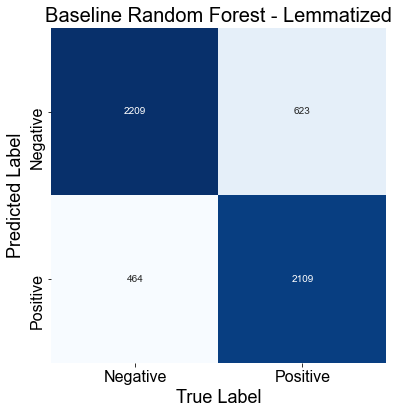

In [49]:
# Plotting a confusion matrix
plt.figure(figsize=(6, 7))
mat = confusion_matrix(y_test_lem, y_rf_base_lem)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Blues")
sns.set(font_scale=2.0)
plt.xlabel('True Label', fontsize= 18)
plt.ylabel('Predicted Label', fontsize= 18)
plt.title('Baseline Random Forest - Lemmatized', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
b, t = plt.ylim() 
plt.ylim(b, t) 
plt.savefig('../images/confusion-matrix-baseline-model.png', bbox_inches = "tight", pad_inches=.5, dpi=300)
plt.show()

We can see above that the best model was able to correctly predict about 79% of the negative reviews and 69% of the negative reviews. You can see a full analysis of the results in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/final-notebook.ipynb">Final Notebook</a>.

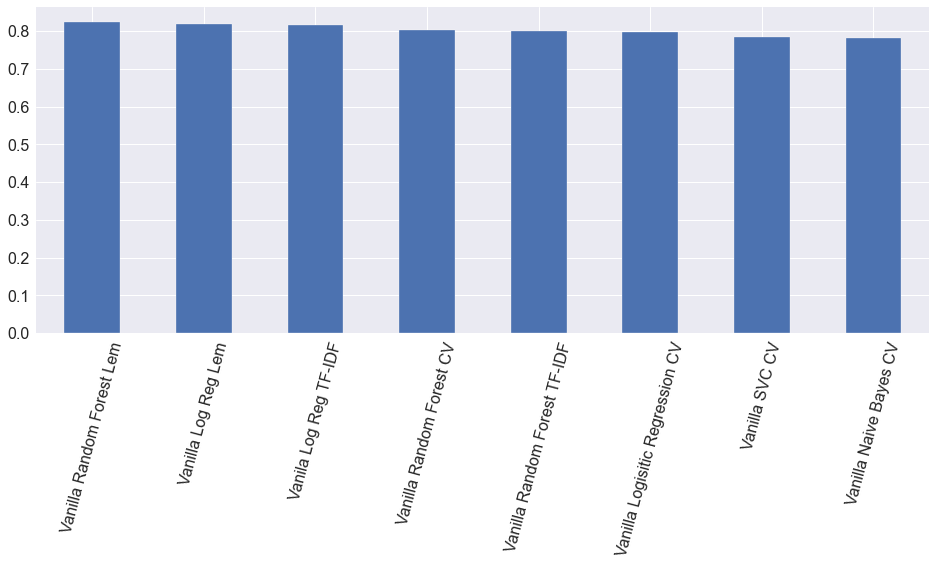

In [50]:
plt.style.use('seaborn')
plt.figure(figsize=(16,6))
evaluation_df['Accuracy'].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=75, fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Ensemble Models

Now, with my best models in mind, I will run a few ensemble models in the <a href="https://github.com/Ismaeltrevi/hotel-reviews-analysis-using-nlp/blob/main/models/ensemble-models.ipynb">Data Cleaning</a>.

# Pickle Files

Pickling files for further use.

In [51]:
# Pickling Train Set - Features
pickle_out = open("../pickle/lg_tfidf.pkl",'wb')
pickle.dump(lg_tfidf, pickle_out)
pickle_out.close()

In [52]:
# Pickling Train Set - Features
pickle_out = open("../pickle/vanilla_model_evaluation.pkl",'wb')
pickle.dump(evaluation_df, pickle_out)
pickle_out.close()

In [53]:
# Pickling Train Set - Features
pickle_out = open("../pickle/X_train_tfidf.pkl",'wb')
pickle.dump(X_train_tfidf, pickle_out)
pickle_out.close()

In [54]:
# Pickling Test Set - Features
pickle_out = open("../pickle/X_test_tfidf.pkl",'wb')
pickle.dump(X_test_tfidf, pickle_out)
pickle_out.close()

In [55]:
# Pickling Train and Test Set  Target
y_train.to_pickle("../pickle/y_train.pkl")
y_test.to_pickle("../pickle/y_test.pkl")

In [56]:
# Pickling Train Set - Features
pickle_out = open("../pickle/X_train_cv.pkl",'wb')
pickle.dump(X_train_cv, pickle_out)
pickle_out.close()

In [57]:
# Pickling Test Set - Features
pickle_out = open("../pickle/X_test_cv.pkl",'wb')
pickle.dump(X_test_cv, pickle_out)
pickle_out.close()

In [58]:
# Pickling Train Set - Features
pickle_out = open("../pickle/rf_lem_model.pkl",'wb')
pickle.dump(rf_lem, pickle_out)
pickle_out.close()

In [59]:
# Pickling Train Set - Features
pickle_out = open("../pickle/X_train_lem.pkl",'wb')
pickle.dump(X_train_lem, pickle_out)
pickle_out.close()

In [60]:
# Pickling Test Set - Features
pickle_out = open("../pickle/X_test_lem.pkl",'wb')
pickle.dump(X_test_lem, pickle_out)
pickle_out.close()

In [61]:
# Pickling Train and Test Set - Target
y_train_lem.to_pickle("../pickle/y_train_lem.pkl")
y_test_lem.to_pickle("../pickle/y_test_lem.pkl")

In [62]:
# Pickle best model using CountVectorizer
pickle_out = open("../pickle/lg_cv.pickle","wb")
pickle.dump(lg_cv, pickle_out)
pickle_out.close()